In [1]:
import os

import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import rasterio
from rasterio.plot import show
from rasterio.plot import plotting_extent


# base
import math
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
from sklearn.metrics.pairwise import haversine_distances
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
import pickle

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib_scalebar.scalebar import ScaleBar
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz, Objective, query_node_attributes
from feems.cross_validation import run_cv, comp_mats


# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

def cov_to_dist(S):
    s2 = np.diag(S).reshape(-1, 1)
    ones = np.ones((s2.shape[0], 1))
    D = s2 @ ones.T + ones @ s2.T - 2 * S
    return(D)

/tmp/ipykernel_387138/2125809390.py:14: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/home/lem/miniconda3/envs/feems_e/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/lem/miniconda3/envs/feems_e/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [8]:
import glob
glob.glob('../../3*/Admixture/*')

['../../3-PopGenStruct/Admixture/Paxil_M095_PutatNeutral.PLINK.log',
 '../../3-PopGenStruct/Admixture/Paxil_M095_PutatNeutral.PLINK.bim',
 '../../3-PopGenStruct/Admixture/admixture.sh',
 '../../3-PopGenStruct/Admixture/Paxil_M095_PutatNeutral.PLINK.bed',
 '../../3-PopGenStruct/Admixture/Paxil_M095_PutatNeutral.PLINK.fam']

In [9]:
(bim, fam, G) = read_plink('../../3-PopGenStruct/Admixture/Paxil_M095_PutatNeutral.PLINK')
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)
n, p = genotypes.shape

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))


Mapping files: 100%|██████████| 3/3 [00:00<00:00, 212.60it/s]


n_samples=63, n_snps=11629


In [19]:
%%time
# setup graph
coord = np.loadtxt('Paxil.coords')  # sample coordinates
outer = np.loadtxt('Paxil.outer')  # outer coordinates
# grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid='ISEA_grid_res9.shp',
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

CPU times: user 8.99 s, sys: 12.1 ms, total: 9 s
Wall time: 9 s


In [20]:
%%time
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

CPU times: user 3min 11s, sys: 215 ms, total: 3min 11s
Wall time: 3min 11s


constant-w/variance fit, converged in 136 iterations, train_loss=169654.6697753
lambda=2.0000000, alpha=0.7531832, converged in 295 iterations, train_loss=162174.8933052
CPU times: user 57.8 s, sys: 49.4 s, total: 1min 47s
Wall time: 8.31 s


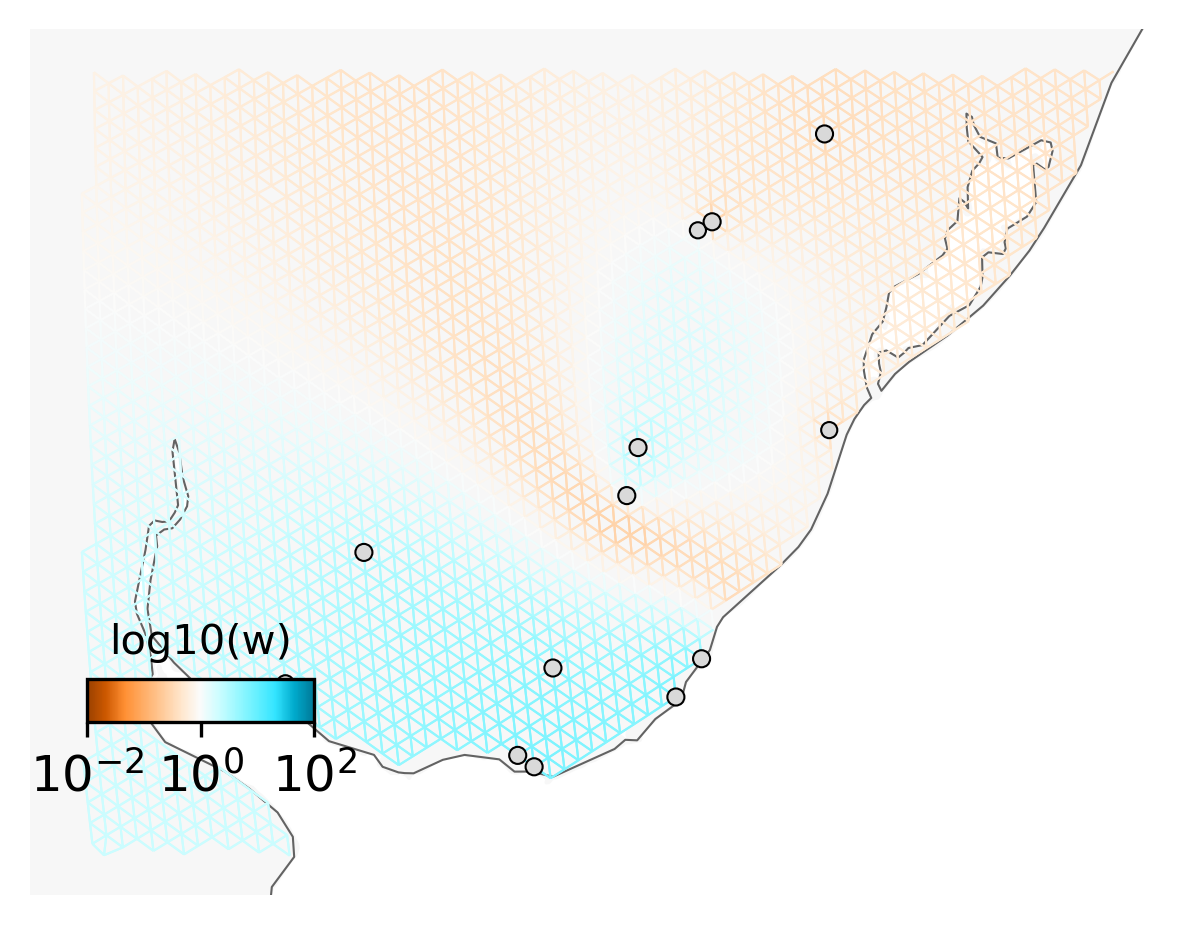

In [21]:
%%time
projection = ccrs.Mercator()

fig = plt.figure(constrained_layout=True, dpi=300, figsize=(6, 6))
spec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)

lamb=2.0
sp_graph.fit(lamb = lamb)


ax = fig.add_subplot(2, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

In [22]:
%%time
pckl_file = "cv_err_Paxil_PutatNeutral.pkl"
if os.path.exists(pckl_file):
    LoadCVFromDisk = True
else:
    LoadCVFromDisk = False


# define grid
# Publication grid for this dataset
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]
# Exploratory grid: 
# lamb_grid = np.geomspace(1e-4, 1e1, 10)[::-1]

# run cross-validation
if not LoadCVFromDisk:
    cv_err = run_cv(sp_graph, lamb_grid, n_folds=sp_graph.n_observed_nodes, factr=1e10)
    pickle.dump(cv_err,open(pckl_file,"wb"))


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1
 fold= 10
iteration lambda=20/20 alpha=1/1
 fold= 11
iteration lambda=20/20 alpha=1/1
 fold= 12
iteration lambda=20/20 alpha=1/1CPU times: user 20min 1s, sys: 18min 33s, total: 38min 34s
Wall time: 2min 37s


0.11288378916846883

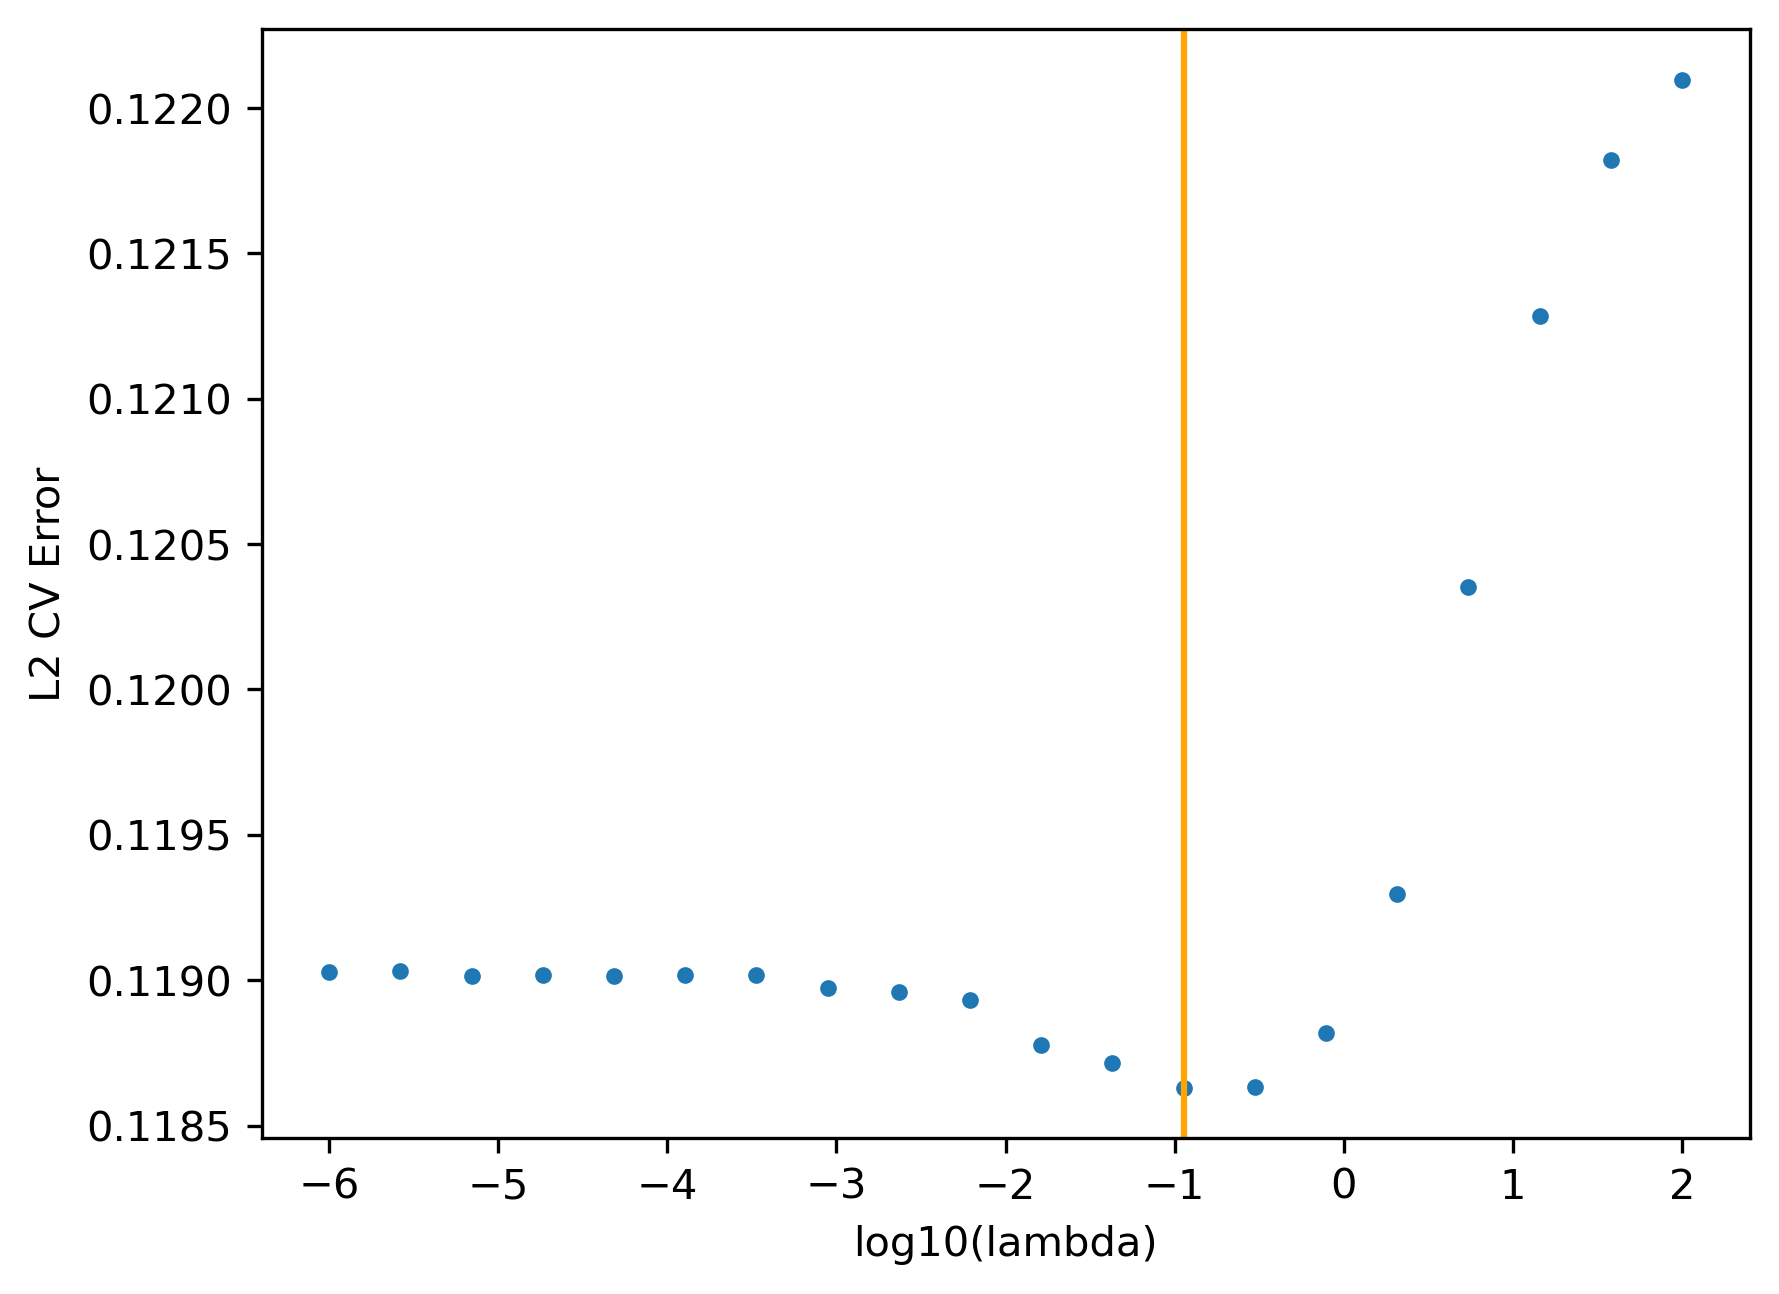

In [23]:
LoadCVFromDisk = True
if LoadCVFromDisk: 
    cv_err = pickle.load(open(pckl_file,"rb"))
    
# average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])

fig, ax = plt.subplots(dpi=300)
ax.plot(np.log10(lamb_grid), mean_cv_err, ".");
ax.set_xlabel("log10(lambda)");
ax.set_ylabel("L2 CV Error");
ax.axvline(np.log10(lamb_cv), color = "orange")
lamb_cv

In [24]:
# re-fit
sp_graph.fit(lamb_cv)

constant-w/variance fit, converged in 136 iterations, train_loss=169654.6697753
lambda=0.1128838, alpha=0.7531832, converged in 464 iterations, train_loss=161278.5392290


In [25]:
# Administrative broders:
bra_adm = gpd.read_file('../../../../maps/shapefiles/BRA_adm1.shp')
arg_adm = gpd.read_file('../../../../maps/shapefiles/ARG_adm1.shp')
uru_adm = gpd.read_file('../../../../maps/shapefiles/URY_adm0.shp')

# Water bodies:
bra_water = gpd.read_file('../../../../maps/shapefiles/URY_water_areas_dcw.shp')
uru_water = gpd.read_file('../../../../maps/shapefiles/BRA_water_areas_dcw.shp')


mercator_proj = ccrs.Mercator()

bbox = box(-59, -35.5, -50, -29.7) # My P. axillaris range

# Loading altitudinal raster layer:
total_alt_clipped = rasterio.open('../../../../maps/rasters/paxil_map_altitude_mercator.tif')

# Merging all the other SHP maps:
total_adm = pd.concat([bra_adm,arg_adm,uru_adm]).reset_index().drop(columns='index')
total_water = pd.concat([bra_water, uru_water]).reset_index().drop(columns='index')

# Filtering the SHP total map: xmin, ymin, xmax, ymax AND reprojecting to Mercator (EPSG:3857)
total_adm_clipped = gpd.clip(total_adm, mask=bbox).to_crs(epsg=4326)
total_water_clipped = gpd.clip(total_water[total_water['HYC_DESCRI'].isin(['Perennial/Permanent'])], mask=bbox).to_crs(epsg=4326) # Only get the water bodies which are Perennial/Permanent

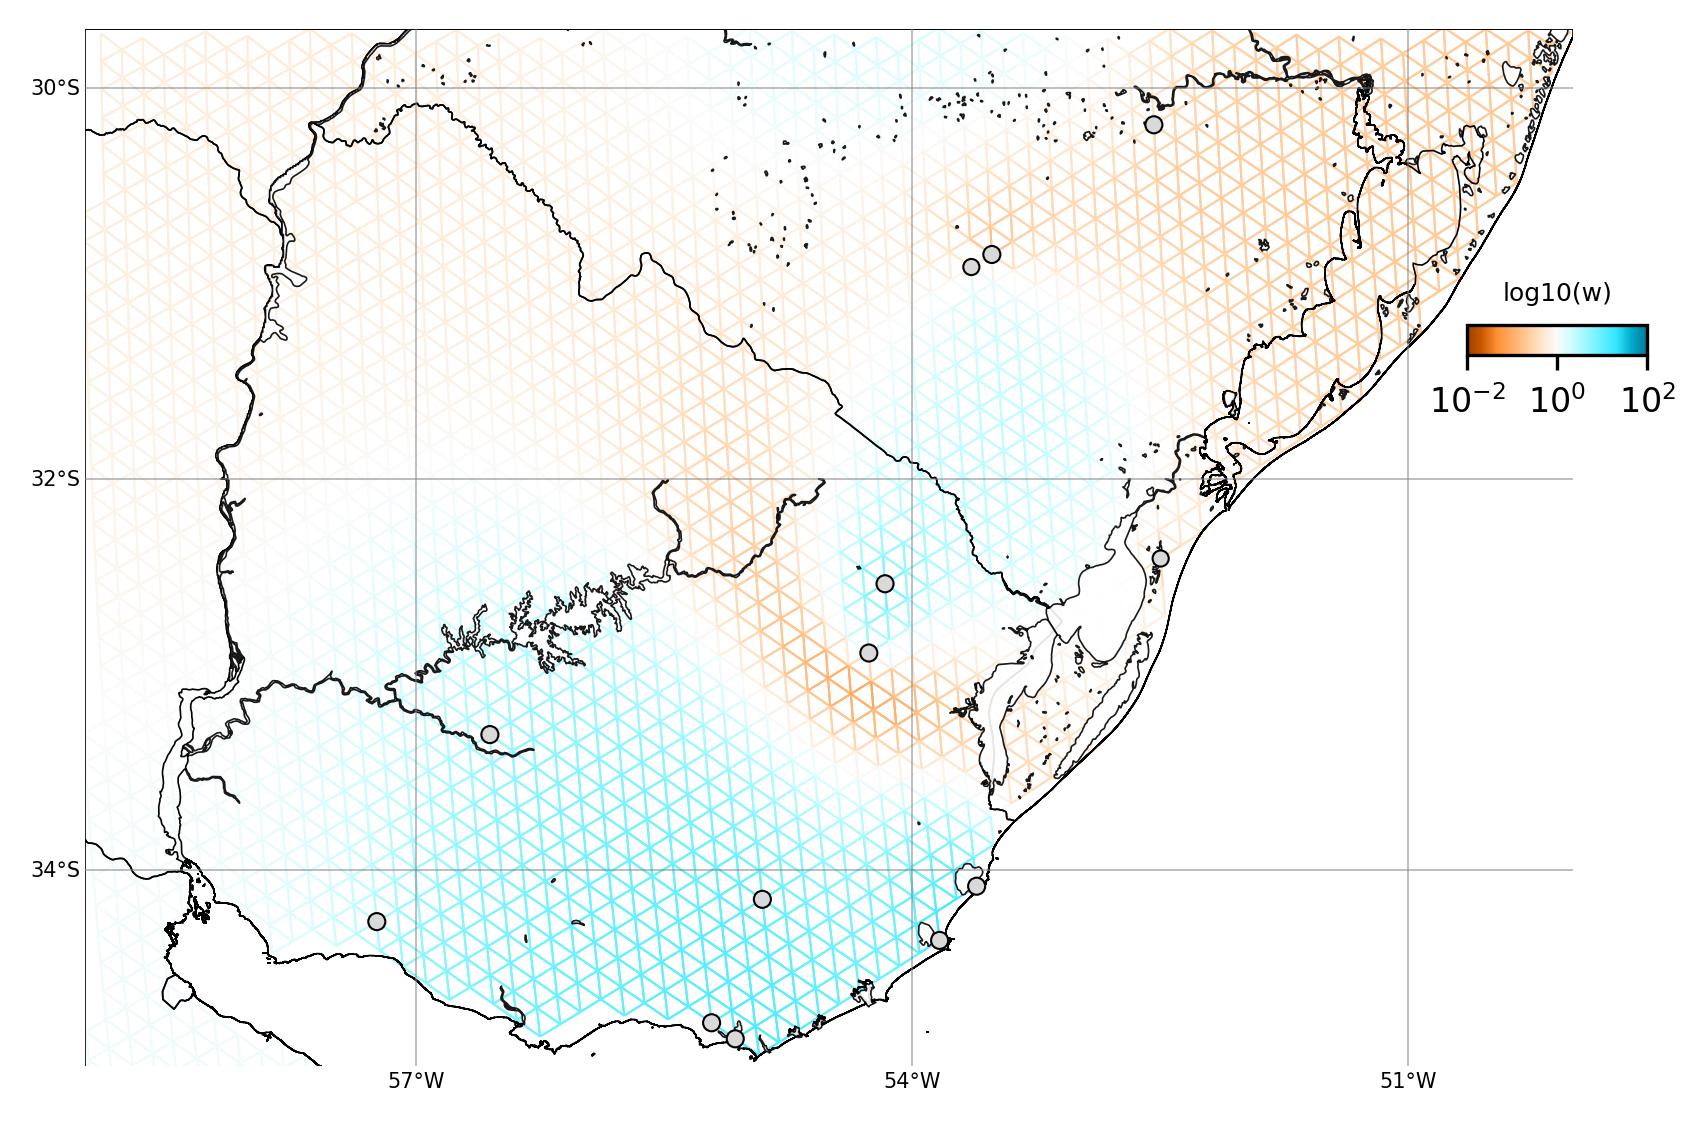

In [26]:
from matplotlib.ticker import MultipleLocator


fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-59, -50, -35, -29.7])
v = Viz(ax, sp_graph, projection=ccrs.PlateCarree(), edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=6, cbar_width=.6, cbar_height=.1, cbar_ticklabelsize=8, cbar_loc="right")
# v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

# rasterio.plot.show(total_alt_clipped, ax=ax, cmap='gray_r')
total_adm_clipped.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.4)
total_water_clipped.plot(ax=ax, facecolor='white', edgecolor='black', alpha=0.9, linewidth=0.4)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.4,
    color='gray',
    alpha=0.6,
    linestyle='-'
)

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 5}
gl.ylabel_style = {'size': 5}
gl.xlocator = MultipleLocator(3)
gl.ylocator = MultipleLocator(2)
ax.margins(x=0, y=0)

fig.savefig("paxil_map_feems_nomiss_result.svg", format="svg", transparent=True, pad_inches=0, bbox_inches='tight')